In [48]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

RNG = np.random.default_rng(42) # Random generator for reprodoctubility

# Data import

In [49]:
# Configuraciones para diferentes posiciones de las anclas (referencias):
# "pos": indica coordenadas cartesianas (m)
# "angulo": indica el ángulo del ancla respecto de la vertical (rad)

config_1 = {
"P1":{"pos": (56.69873, 75.0),"angulo": -1.0471975493043784},
"P2":{"pos": (94.770655, 109.771682),"angulo": -0.08726646965814552},
"P3":{"pos": (135.355339, 85.355339),"angulo": 0.7853981633974481}
}

config_2 = {
"P1":{"pos": (64.644661, 85.355339),"angulo": -0.7853981633974483},
"P2":{"pos": (34.467836, 95.886115),"angulo": -0.9599310909314129},
"P3":{"pos": (39.818498, 129.863551),"angulo": -0.6457718207490258}
}

config_3 = {
"P1":{"pos": (64.644661, 85.355339),"angulo": -0.7853981633974483},
"P2":{"pos": (40.548414, 103.530449),"angulo": -0.8377580360740813},
"P3":{"pos": (35.721239, 126.604444),"angulo": -0.6981317030426971}
}

config_4 = {
"P1":{"pos": (64.644661, 85.355339),"angulo": -0.7853981633974483},
"P2":{"pos": (43.332813, 106.469726),"angulo": -0.7871434894299918},
"P3":{"pos": (29.412843, 120.833984),"angulo": -0.7836528320585269}
}

# Posición esperada para el objetivo
p = (100, 50)


In [50]:
# Every import to numpy

theta_1 = np.array([config_1[p]['angulo'] for p in config_1.keys()])
pos_1   = np.array([config_1[p]['pos']    for p in config_1.keys()])

theta_2 = np.array([config_2[p]['angulo'] for p in config_2.keys()])
pos_2   = np.array([config_2[p]['pos']    for p in config_2.keys()])

theta_3 = np.array([config_3[p]['angulo'] for p in config_3.keys()])
pos_3   = np.array([config_3[p]['pos']    for p in config_3.keys()])

theta_4 = np.array([config_4[p]['angulo'] for p in config_4.keys()])
pos_4   = np.array([config_4[p]['pos']    for p in config_4.keys()])

angles_clean = np.stack([theta_1, theta_2, theta_3, theta_4])
positions_clean = np.stack([pos_1, pos_2, pos_3, pos_4])

# 1. Modelo matemático
$$
A \cdot \hat p = b,
\qquad
A =
\begin{pmatrix}
\cos\theta_1 & -\sin\theta_1 \\
\cos\theta_2 & -\sin\theta_2 \\
\vdots       & \vdots        \\
\cos\theta_i & -\sin\theta_i
\end{pmatrix},
\qquad
\hat p =
\begin{pmatrix}
x \\
y
\end{pmatrix},
\qquad
b =
\begin{pmatrix}
x_1\cos\theta_1 - y_1\sin\theta_1 \\
x_2\cos\theta_2 - y_2\sin\theta_2 \\
\vdots                                \\
x_i\cos\theta_i - y_i\sin\theta_i
\end{pmatrix},
$$

Dado que el sistema es sobredeterminado, donde se toman 3 mediciones por configuración, la solución estimada se obtiene mediante mínimos cuadrados:


$$ \hat p = (A^\top A)^{-1} A^\top b $$

En la práctica, las mediciones angulares están afectadas por ruido. Cada ángulo observado se modela como

$$
\theta_i^{\text{obs}} = \theta_i + \varepsilon_i,
\qquad 
\varepsilon_i \sim \mathcal N(0,\sigma^2)
$$

de modo que las matrices $A$ y $b$ utilizadas en la estimación se construyen a partir de $\theta_i^{\text{obs}}$
y no de los valores verdaderos. La estabilidad del estimador de mínimos cuadrados depende críticamente del
número de condición de la matriz de diseño,


$$ \kappa(A) = \frac{\sigma_{\max}(A)}{\sigma_{\min}(A)} $$


In [51]:
def estimate_p(angles, positions):
    A = np.column_stack([np.cos(angles), -np.sin(angles)])    # Design matrix
    b = np.sum(A * positions, axis = 1) # Solutions for linear system
    x, *_ = np.linalg.lstsq(A, b, rcond=None)  # Least Squares solution
    return  x, np.linalg.cond(A), A

# 2. Simulacion
## Estimación exacta del punto 
$$ p = (A^\top A)^{-1} A^\top b $$

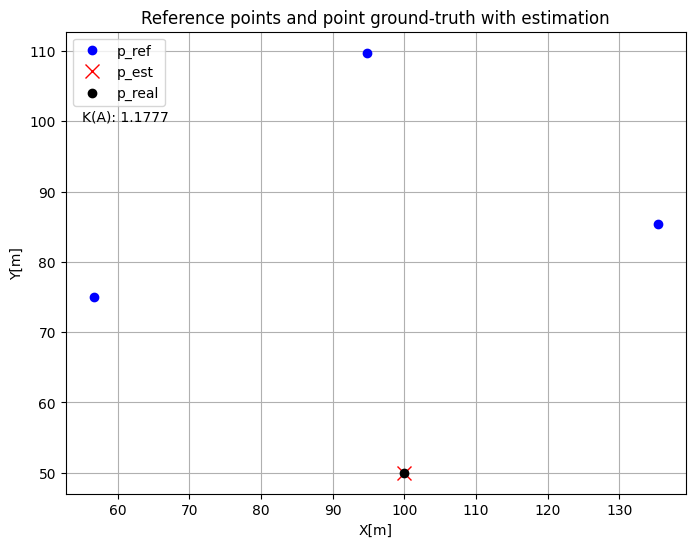

In [52]:
x, cond, _ = estimate_p(theta_1, pos_1)

plt.figure(figsize=(8,6))
plt.plot(pos_1[:,0], pos_1[:,1], 'o', color='blue', label='p_ref')
plt.plot(x[0], x[1], 'x', markersize=10.0, color='red', label='p_est')
plt.plot(p[0], p[1], 'o', color='black', label='p_real')
plt.title('Reference points and point ground-truth with estimation')
plt.text(55, 100, f'K(A): {cond:.4f}')
plt.legend(loc='upper left')
plt.xlabel('X[m]')
plt.ylabel('Y[m]')
plt.grid(True)
plt.show()

## Estimación con incertidumbre en las posiciones de las referencias

Analicemos cómo afecta a la estimación del punto objetivo \(p\) la presencia de ruido gaussiano en las posiciones de las referencias.

```math
\tilde{p}_i = (x_i + \Delta x_i,\; y_i + \Delta y_i),
```

donde los términos de ruido cumplen:

```math
\Delta x_i \sim \mathcal{N}(0, \sigma^2), \qquad
\Delta y_i \sim \mathcal{N}(0, \sigma^2),
```

y son estadísticamente independientes entre sí.  
El ruido se evalúa para distintas varianzas:

```math
\sigma^2 \in \{4,\; 25,\; 100\}.
```

Para cada nivel de ruido se generan 50 realizaciones de la estimación del punto \(p\), resolviendo el problema de mínimos cuadrados utilizando las referencias perturbadas. Cada estimación obtenida se representa en el plano de coordenadas, superponiendo las 50 realizaciones para visualizar la dispersión inducida por el ruido espacial.


In [53]:
def generate_gaussian_noisy_samples(reference_tensor, sigma, num_samples, axis, rng):
    """
    Insert a new axis into `reference_tensor`, tile it `num_samples` times
    along that axis, and add Gaussian noise.

    Parameters:
        reference_tensor : np.ndarray
            Original data of any shape.
        sigma : float
            Standard deviation of Gaussian noise.
        num_samples : int
            Number of noisy replicas along the new axis.
        axis : int, default 0
            Axis where the new dimension will be inserted.
        rng : np.random.Generator, optional
            Random generator.

    Returns:
        np.ndarray
            Array of shape obtained by inserting axis with size num_samples.
    """
    # Make memory layout deterministic
    reference_tensor = np.ascontiguousarray(reference_tensor)

    # Insert a new axis
    expanded = np.expand_dims(reference_tensor, axis=axis)

    # Tile the data along the new axis
    tile_shape = [1] * expanded.ndim
    tile_shape[axis] = num_samples
    tiled = np.tile(expanded, tile_shape)

    # Generate noise with identical shape
    noise = rng.normal(0, sigma, size=tiled.shape)

    return tiled + noise

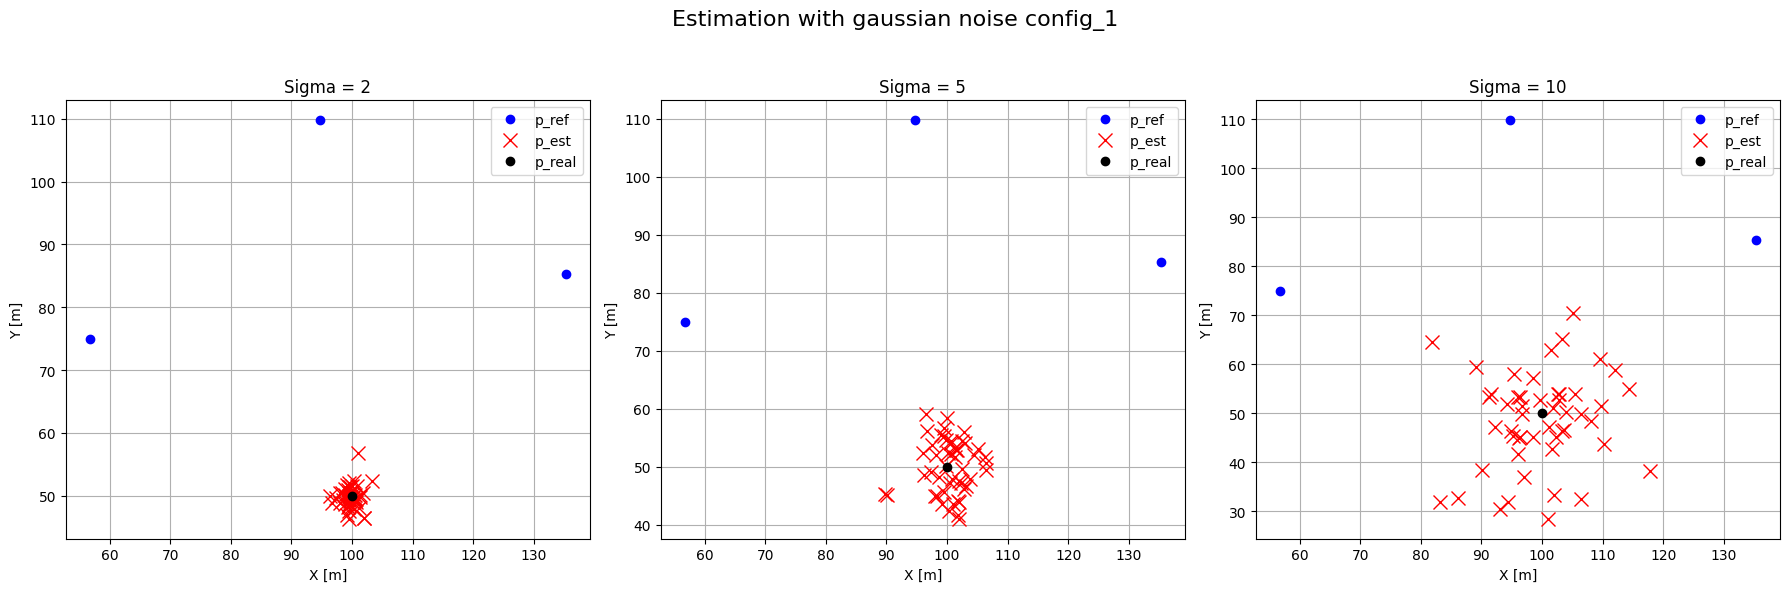

In [54]:
# Introducing gaussian noise to reference points's coordinates
SAMPLES = 50

sigmas = (2, 5, 10)
estimations = np.zeros((3, SAMPLES, 2))
for k in range(len(sigmas)):
    noisy_sampling = generate_gaussian_noisy_samples(pos_1, sigmas[k], SAMPLES, 0, RNG)
    for i in range(noisy_sampling.shape[0]):
        x, *_ = estimate_p(theta_1, noisy_sampling[i])
        estimations[k, i] = x

n = estimations.shape[0]

fig, axes = plt.subplots(1, n, figsize=(6*n, 6))

for i in range(n):
    ax = axes[i] if n > 1 else axes
    
    ax.plot(pos_1[:,0], pos_1[:,1], 'o', color='blue', label='p_ref')
    ax.plot(estimations[i,:,0], estimations[i,:,1], 'x', markersize=10.0, 
            color='red', label='p_est')
    ax.plot(p[0], p[1], 'o', color='black', label='p_real')
    
    ax.set_title(f'Sigma = {sigmas[i]}')
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.grid(True)
    ax.legend(loc='upper right')

plt.suptitle('Estimation with gaussian noise config_1', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Amplificación de errores
Estimemos la posición con ruido de varianza σ² = 4 para config_2, config_3 y config_4, se observa que las configuraciones con mayor número de condición κ.

El código inluye una estimación promedio calculada como el promedio muestral de todas las estimaciones gracias a que resulta matemáticamente equivalente a calcular la estimación sobre el promedio de las observaciones:

```math
\frac{1}{N} \sum_{k=1}^N \hat{x}_k
= \frac{1}{N} \sum_{k=1}^N (A^\top A)^{-1} A^\top b_k
= (A^\top A)^{-1} A^\top \frac{1}{N} \sum_{k=1}^Nb_k
```

La matriz de diseño no depende de las posiciones sino del ángulo.

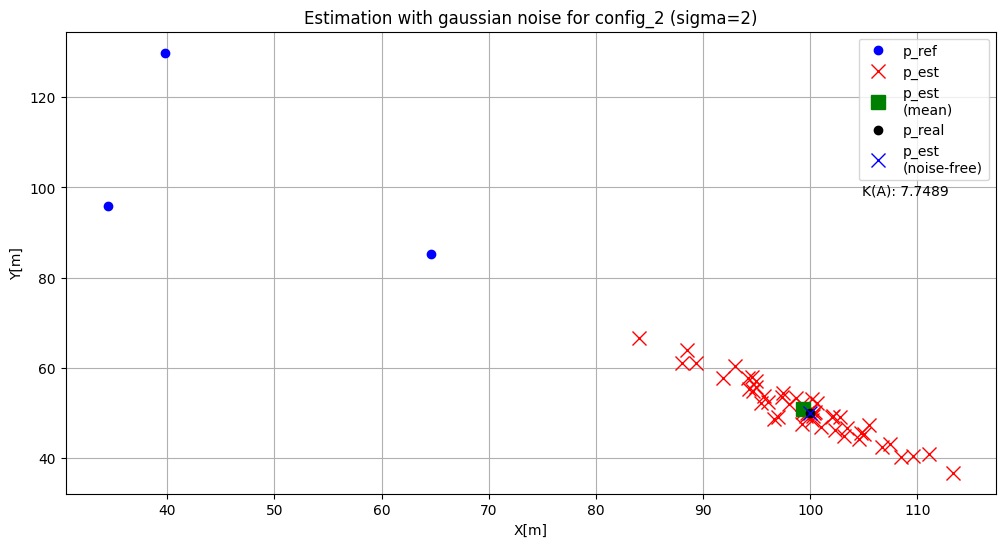

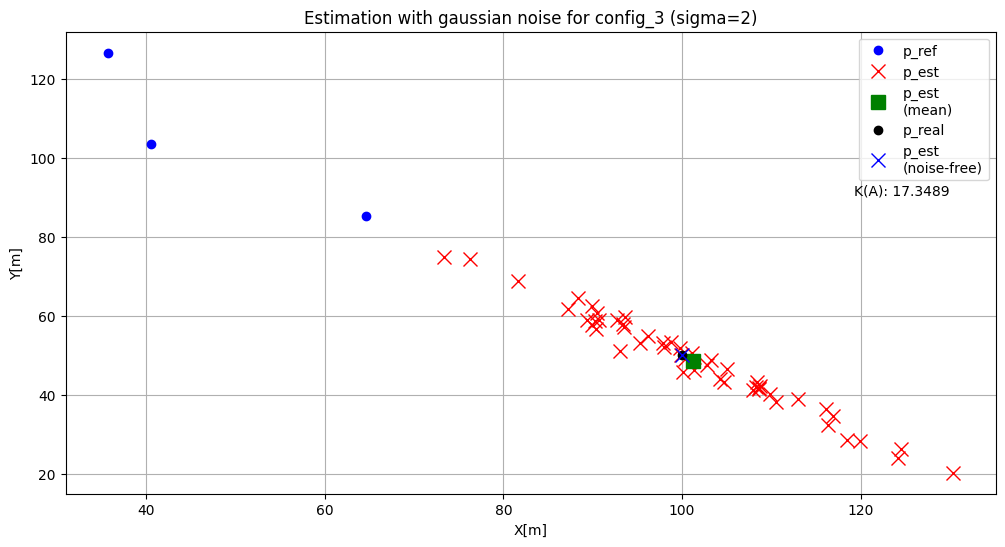

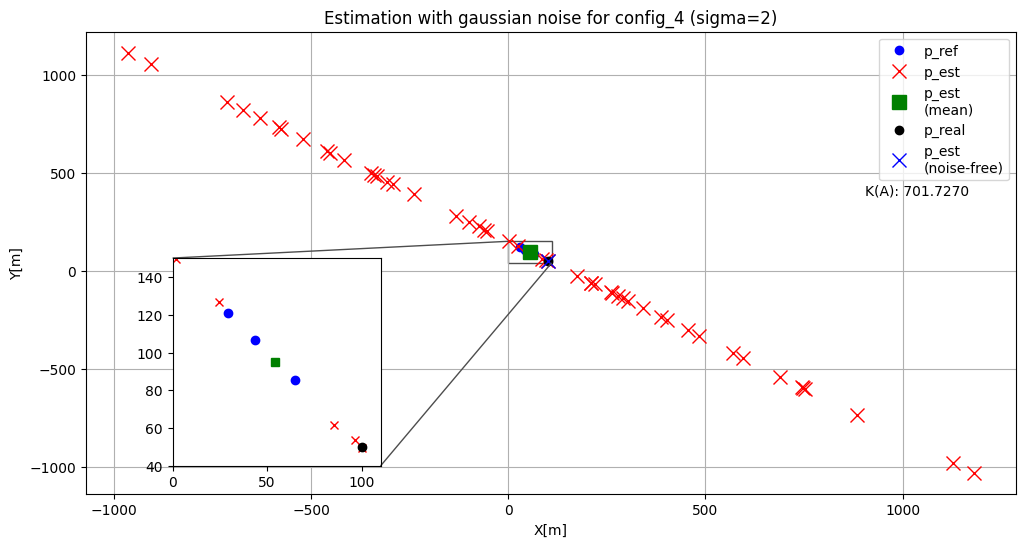

In [55]:
# Introducing gaussian noise into observed angles
angles_234 = np.array(angles_clean[1:,:])
pos_234 = np.array(positions_clean[1:,:])
# First we get the solution without noise and condition number of design matrix for a later comparison
sigma = 2
conditions = np.zeros(3)
clean_solutions = np.zeros((3, 2))
estimations = np.zeros((SAMPLES, 3, 2))
noisy_pos = generate_gaussian_noisy_samples(pos_234, sigma, SAMPLES, 1, RNG)
for config in range(3):
    clean_solutions[config], conditions[config], _ = estimate_p(angles_234[config], pos_234[config])
    for sample in range(SAMPLES):
        x, *_ = estimate_p(angles_234[config], noisy_pos[config, sample])
        estimations[sample, config] = x

for i in range(3):
    fig, ax = plt.subplots(figsize=(12,6))
    plt.plot(pos_234[i,:,0], pos_234[i,:,1], 'o', color='blue', label='p_ref')
    plt.plot(estimations[:,i,0], estimations[:,i,1], 'x', markersize=10.0, color='red', label='p_est')
    plt.plot(np.mean(estimations[:,i,0]), np.mean(estimations[:,i,1]), 's', markersize=10.0, color='green', label='p_est\n(mean)')
    plt.plot(p[0], p[1], 'o', color='black', label='p_real')
    plt.plot(clean_solutions[i][0], clean_solutions[i][1], 'x', markersize=10.0, color='blue', label='p_est\n(noise-free)')

    plt.title(f'Estimation with gaussian noise for config_{i+2} (sigma={sigma})')
    leg = plt.legend(loc='upper right')
    # For text alignment
    plt.gcf().canvas.draw()
    bb = leg.get_bbox_to_anchor().transformed(plt.gca().transAxes.inverted())
    plt.text(0.95, 0.67, f'K(A): {conditions[i]:.4f}', transform=plt.gca().transAxes, ha='right', va='top')
    plt.xlabel('X[m]')
    plt.ylabel('Y[m]')
    plt.grid(True)
    if np.max(np.linalg.norm(p-estimations[:,i])) > 1000:
        # A bit of zoom
        axins = inset_axes(ax,
                        width="35%",
                        height="45%",
                        loc="lower left",
                        borderpad=2)

        axins.plot(estimations[:,i,0], estimations[:,i,1],'x',  color='red')
        axins.plot(pos_234[i,:,0], pos_234[i,:,1], 'o', color='blue')
        axins.plot(p[0], p[1], 'o', color='black')
        axins.set_xlim(0, 110)
        axins.set_ylim(40, 150)
        axins.plot(np.mean(estimations[:,i,0]), np.mean(estimations[:,i,1]), 's', color='green')
        mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.3")
        axins.set_aspect('equal', adjustable='box')
    plt.show()

## Sensibilidad numérica en mínimos cuadrados (versión reducida)

En un sistema de mínimos cuadrados:

```math
A \cdot p \approx b ,
```

pequeñas perturbaciones en los datos (por ejemplo, ruido en los ángulos) producen cambios en la matriz de diseño \(A\), lo que afecta la solución. La teoría de perturbaciones establece que:

```math
\frac{\| p_{\text{noisy}} - p_{\text{clean}} \|}{\| p_{\text{clean}} \|}
\;\approx\;
\kappa(A)
\cdot
\frac{\| \Delta A \|}{\|A\|},
```

donde $\Delta A = A_{\text{noisy}} - A_{\text{clean}}$. Un $\kappa(A)$ (número de condición) bajo implica un sistema estable; valores grandes significan que el ruido se amplifica fuertemente. 

Generalmente, $\| p_{\text{noisy}} - p_{\text{clean}} \| \propto \kappa(A)$, por lo que configuraciones con mayor número de condición presentan soluciones mucho más sensibles al ruido. Para medir la amplificación del error tomamos algunas métricas sobre simulaciones montecarlo tomadas a partir de los sistemas definidos según todas las configuraciones dadas.

- **Perturbación del diseño**: $\| A_{\text{noisy}} - A_{\text{clean}} \|_F$

- **Error absoluto**: $\| p_{\text{noisy}} - p_{\text{clean}} \|$
- **Error relativo**: $\frac{\| p_{\text{noisy}} - p_{\text{clean}} \|}{\| p_{\text{clean}} \|}$

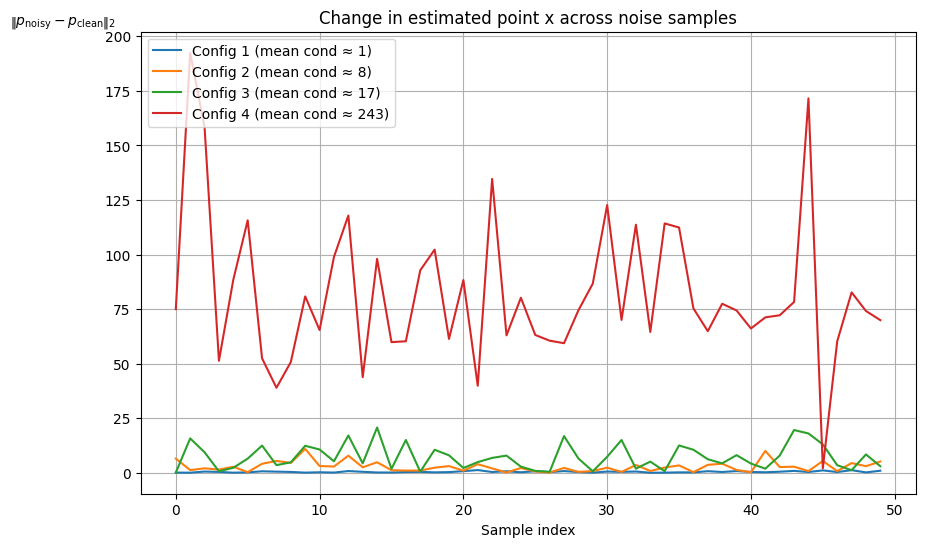

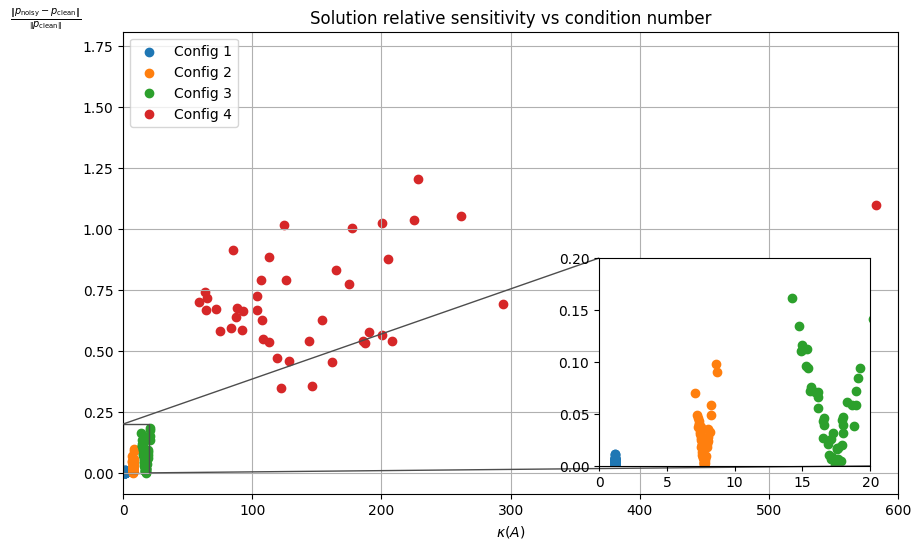

In [56]:
sigma = 0.01

N_CONFIGS = 4

def noisy_angles(angles):
    return angles + RNG.normal(0, sigma, size=angles.shape)

# Clean solutions and clean matrices
x_clean = np.zeros((N_CONFIGS, 2))
clean_cond = np.zeros(N_CONFIGS)
clean_As = []

for j in range(N_CONFIGS):
    xc, condA, A_clean = estimate_p(angles_clean[j], positions_clean[j])
    x_clean[j] = xc
    clean_cond[j] = condA
    clean_As.append(A_clean)

# Storage for Monte Carlo
cond_values = np.zeros((SAMPLES, N_CONFIGS))
x_diff_norm = np.zeros((SAMPLES, N_CONFIGS))
x_diff_rel  = np.zeros((SAMPLES, N_CONFIGS))

# Monte Carlo loop
for s in range(SAMPLES):
    noisy = noisy_angles(angles_clean)

    for j in range(N_CONFIGS):
        x_noisy, condA, A_noisy = estimate_p(noisy[j], positions_clean[j])

        cond_values[s, j] = condA
        dx = x_noisy - x_clean[j]
        x_diff_norm[s, j] = np.linalg.norm(dx)
        x_diff_rel[s, j]  = x_diff_norm[s, j] / np.linalg.norm(x_clean[j])

# norm(p_noisy - p_clean)
plt.figure(figsize=(10,6))
for j in range(N_CONFIGS):
    plt.plot(x_diff_norm[:, j], label=f"Config {j+1} (mean cond ≈ {np.mean(cond_values[:,j]):.0f})")
plt.xlabel("Sample index")
plt.ylabel(r"$\left\Vert p_{\text{noisy}} - p_{\text{clean}} \right\Vert_2$", rotation=0)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.1, 1)
plt.title("Change in estimated point x across noise samples")
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

# cond(A) vs ||p_noisy - p_clean|| rel
plt.figure(figsize=(10,6))
for j in range(N_CONFIGS):
    plt.scatter(cond_values[:, j], x_diff_rel[:, j], label=f"Config {j+1}")
plt.xlim(0, 600)    # for visualization
plt.xlabel(r"$\kappa(A)$")
plt.ylabel(
    r"$\frac{\left\Vert p_{\text{noisy}} - p_{\text{clean}} \right\Vert}{\left\Vert p_{\text{clean}} \right\Vert}$", 
    rotation=0)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.1, 1)
plt.title("Solution relative sensitivity vs condition number")
plt.grid(True)
plt.legend(loc='upper left')
# A bit of zoom
axins = inset_axes(ax,
                   width="35%",
                   height="45%",
                   loc="lower right",
                   borderpad=2)

for j in range(N_CONFIGS):
    axins.scatter(cond_values[:, j], x_diff_rel[:, j])

axins.set_xlim(0, 20)
axins.set_ylim(0, 0.20)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.3")
plt.show()

# 3. Experimento

In [57]:
import utm

# Posición objetivo
p_latlon = (-34.446625402358016, -58.52936138813481)

# Referencias
ref1_latlon = (-34.4462289155478, -58.529179680546946)
ref2_latlon = (-34.44669009614473, -58.529913264726524)
ref3_latlon = (-34.446615492363755, -58.52877675356462)

# Ángulos hacia cada referencia (en radianes)
theta1 = 0.4107
theta2 = 4.5110
theta3 = 1.4472

# Conversión de coordenadas geográficas (lat, lon) a coordenadas cartesianas UTM (x, y)
# Esto permite trabajar en un sistema métrico plano compatible con el modelo lineal del TP.
p_utm = np.array(utm.from_latlon(*p_latlon)[:2])

# Posiciones UTM de las referencias
r1 = np.array(utm.from_latlon(*ref1_latlon)[:2])
r2 = np.array(utm.from_latlon(*ref2_latlon)[:2])
r3 = np.array(utm.from_latlon(*ref3_latlon)[:2])

refs = np.vstack([r1, r2, r3])
thetas = np.array([theta1, theta2, theta3])

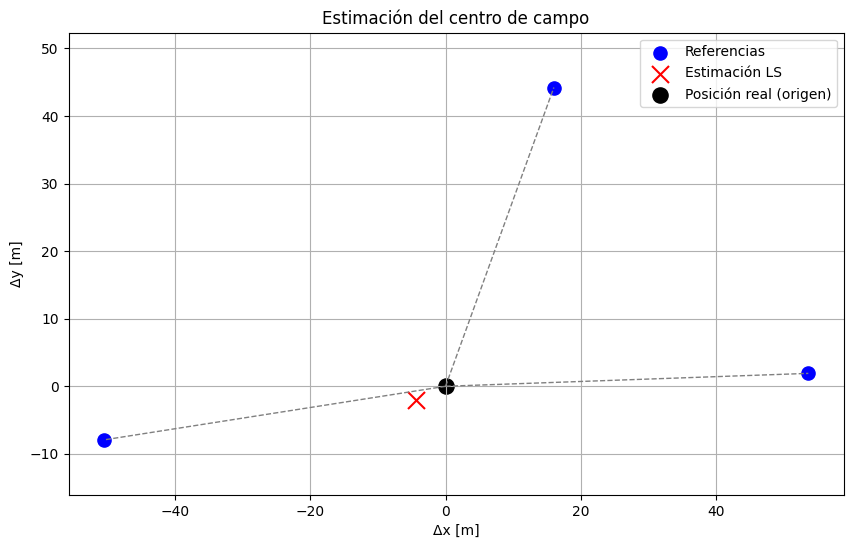

In [58]:
# Ahora estimamos con estimate_p
p_est = estimate_p(thetas, refs)[0]

# Centramos todo para visualizar
x0, y0 = p_utm
refs_c = refs - np.array([x0, y0])
p_est_c = p_est - np.array([x0, y0])
p_real_c = np.array([0, 0])

plt.figure(figsize=(10,6))
plt.scatter(refs_c[:,0], refs_c[:,1], c="blue", s=90, label="Referencias")
plt.scatter(p_est_c[0], p_est_c[1], c="red", marker="x", s=150, label="Estimación LS")
plt.scatter(0, 0, c="black", s=120, label="Posición real (origen)")
for (x,y) in refs_c:
    plt.plot([0, x], [0, y], linestyle="--", color="gray", linewidth=1)
plt.xlabel("Δx [m]")
plt.ylabel("Δy [m]")
plt.title("Estimación del centro de campo")
plt.grid(True)
plt.legend()
plt.axis("equal")
plt.show()